In [0]:
"""
    Reconstructiong MNIST images using a Deep Convolution GAN
    
    This is the most challenging thing i've done till the date 22/09/2018
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# creating minibatches
def mini_batch(X, size):
    # generate random integers of shape size*1 and in range 0 to len(X)
    # treat x_bat as indices and return values from X at those indices
    x_bat = X[np.random.randint(len(X), size = (size,1))]
    x_bat = x_bat.reshape(size, 28, 28, 1)
    
    return x_bat

11493376/11490434 [==============================] - 0s 0us/step


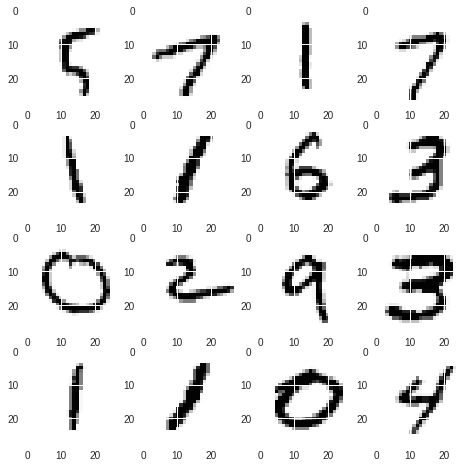

In [3]:
# importing dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

del(y_train, y_test)

fig = plt.figure(figsize=(8,8))

col = 4
row = 4
j = 0

for i in range(1, row*col+1):
    fig.add_subplot(row, col, i)
    plt.imshow(x_train[j+100])
    j+=1
plt.show()

In [0]:
tf.reset_default_graph()

# input and labels placeholders
fake_x = tf.placeholder(tf.float32, [None, 4,4,1])  
real_x = tf.placeholder(tf.float32, [None, 28,28,1])


# generator network weights
gen_wt = {'w_c1': tf.get_variable('w_c1', [3,3,1,64], initializer=tf.contrib.layers.xavier_initializer()),
              'w_c2': tf.get_variable('w_c2', [3,3,64,128], initializer=tf.contrib.layers.xavier_initializer()),
              'w_c3': tf.get_variable('w_c3', [3,3,128,128], initializer=tf.contrib.layers.xavier_initializer()),
              'w_c4': tf.get_variable('w_c4', [3,3,128,1], initializer=tf.contrib.layers.xavier_initializer())
    
}
# discriminator network weights
dis_wt = {'d_c1': tf.get_variable('d_c1', [3,3,1,32], initializer=tf.contrib.layers.xavier_initializer()), 
              'd_c2': tf.get_variable('d_c2', [3,3,32,64], initializer=tf.contrib.layers.xavier_initializer()),
              'd_c3': tf.get_variable('d_c3', [3,3,64,64], initializer=tf.contrib.layers.xavier_initializer()),
              'd_c4': tf.get_variable('d_c4', [3,3,64,1], initializer=tf.contrib.layers.xavier_initializer())
}

In [0]:
# generator network
with tf.device('/gpu:0'):
    def generator(noise):
        # changed relu to tanh
        conv_1 = tf.nn.tanh(tf.nn.conv2d(noise, gen_wt['w_c1'], strides=[1,1,1,1], padding='SAME'))

        up_scale_1 = tf.image.resize_images(conv_1, [14,14], method = tf.image.ResizeMethod.BILINEAR)

        conv_2 = tf.nn.tanh(tf.nn.conv2d(up_scale_1, gen_wt['w_c2'], strides=[1,1,1,1], padding='SAME'))

        drop_2 = tf.nn.dropout(conv_2, 0.8)

        up_scale_2 = tf.image.resize_images(drop_2, [28,28], method = tf.image.ResizeMethod.BILINEAR)

        conv_3 = tf.nn.tanh(tf.nn.conv2d(up_scale_2, gen_wt['w_c3'], strides=[1,1,1,1], padding='SAME'))

        generator = tf.nn.tanh(tf.nn.conv2d(conv_3, gen_wt['w_c4'], strides=[1,1,1,1], padding='SAME'))
        
        return generator
    

    # discriminator network
    def discriminator(imgs):
        ## changed activation from leaky relu to tanh 
        ## changed avg_pool to strided convolution
        
        c1 = tf.nn.tanh(tf.nn.conv2d(imgs, dis_wt['d_c1'], strides=[1,1,1,1], padding='SAME'))
        # m1 = tf.nn.avg_pool(c1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
        c2 = tf.nn.tanh(tf.nn.conv2d(c1, dis_wt['d_c2'], strides=[1,2,2,1], padding='SAME'))
        # m2 = tf.nn.avg_pool(c2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        d2 = tf.nn.dropout(c2, 0.8)
    
        c3 = tf.nn.tanh(tf.nn.conv2d(d2, dis_wt['d_c3'], strides=[1,2,2,1], padding='SAME'))
        #m3 = tf.nn.avg_pool(c3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        d3 = tf.nn.dropout(c3, 0.8)
    
        f4 = tf.layers.flatten(d3)
        d4 = tf.layers.dense(f4, 16, activation='sigmoid', trainable=True)
        discriminator = tf.layers.dense(d4,  1, activation='sigmoid', trainable=True)
        
        return discriminator
    
    # loss and optimization
    
    # generate fake images from noise
    g_output = generator(fake_x)
    # use the discriminator to differentiate between real and fake images
    real_prob = discriminator(real_x)
    fake_prob = discriminator(g_output)
    
    # loss function for discriminator
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_prob, labels=tf.zeros_like(real_prob)) +
                           tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_prob, labels=tf.ones_like(fake_prob)))
    # loss function for generator
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_prob, labels=tf.ones_like(fake_prob)))
    
    # optimizer for discriminator
    d_ops = tf.train.AdamOptimizer(0.0001).minimize(d_loss)
    # optimizer for generator
    g_ops = tf.train.AdamOptimizer(0.0001).minimize(g_loss)
   

In [0]:
# hyperparameters
sample_size = 512
epochs = 1000
s = tf.Session(config=tf.ConfigProto(log_device_placement=True))
s.run(tf.global_variables_initializer())


g_l = []
d_l = []

# here goes the training
for i in range(epochs):
    # create noise sample
    noise = np.random.normal(0, 0.1,[sample_size, fake_x.shape[1], fake_x.shape[2], fake_x.shape[3]])
    # create sample of real images
    real_imgs = mini_batch(x_train, sample_size)/255.0
    
    for j in range(1):
        # training the discriminator
        s.run(d_ops, {real_x: real_imgs, fake_x: noise})
        d_l.append(s.run(d_loss, {real_x: real_imgs, fake_x: noise}))
    
    # training the generator
    s.run(g_ops, {fake_x: noise})
    g_l.append(s.run(g_loss, {fake_x: noise}))

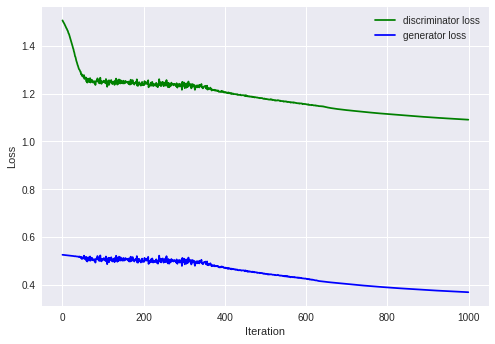

In [53]:
# plotting loss
plt.plot(range(0,len(d_l)), d_l, 'g', label='discriminator loss')
plt.plot(range(0,len(g_l)), g_l, 'b', label='generator loss')
plt.legend(loc='upper right')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

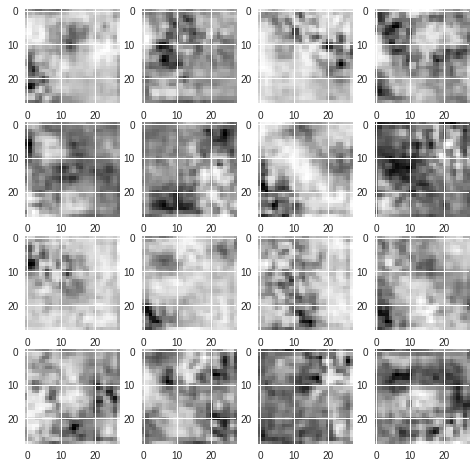

In [54]:
pred = s.run(g_output, {fake_x: np.random.normal(0, 0.1,[sample_size,4,4,1])}).reshape(sample_size, 28,28)
fig2 = plt.figure(figsize=(8,8))

col = 4
row = 4
j = 0

for i in range(1, row*col+1):
    fig2.add_subplot(row, col, i)
    plt.imshow(pred[j])
    j+=1
plt.show()

### It's quite a challenging thing to train a GAN...